<a href="https://colab.research.google.com/github/eisbetterthanpi/vision/blob/main/vicreg_res.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://arxiv.org/pdf/2105.04906.pdf
# https://github.com/facebookresearch/vicreg


In [2]:
# @title augmentations
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# https://github.com/facebookresearch/vicreg/blob/main/augmentations.py

from PIL import ImageOps, ImageFilter
import numpy as np
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

class GaussianBlur(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if np.random.rand() < self.p:
            sigma = np.random.rand() * 1.9 + 0.1
            # return img.filter(ImageFilter.GaussianBlur(sigma))
            return transforms.GaussianBlur(kernel_size=5, sigma=sigma)(img)
        else:
            return img

class Solarization(object):
    def __init__(self, p):
        self.p = p
    def __call__(self, img):
        if np.random.rand() < self.p:
            return ImageOps.solarize(img)
        else:
            return img


class TrainTransform(object):
    def __init__(self):
        self.transform = transforms.Compose([
                # transforms.RandomResizedCrop(32, interpolation=InterpolationMode.BICUBIC),#224
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8,),
                transforms.RandomGrayscale(p=0.2),
                GaussianBlur(p=1.0),
                Solarization(p=0.0),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        self.transform_prime = transforms.Compose([
                # transforms.RandomResizedCrop(32, interpolation=InterpolationMode.BICUBIC),#224
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8,),
                transforms.RandomGrayscale(p=0.2),
                GaussianBlur(p=0.1),
                Solarization(p=0.2),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

    def __call__(self, sample):
        # print("sample.shape",sample.shape)
        # sample=torch.squeeze(sample)
        # sample=transforms.ToPILImage()(sample)
        # sample = torch.vmap(transforms.ToPILImage(),sample)
        x1 = self.transform(sample)
        x2 = self.transform_prime(sample)
        # x2 = transforms.ToTensor()(sample)
        return x1, x2


In [3]:
# @title data
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor #, Lambda, Compose
import matplotlib.pyplot as plt
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

# train_data = datasets.FashionMNIST(root="data", train=True, download=True,transform=ToTensor(),)
# test_data = datasets.FashionMNIST(root="data", train=False, download=True,transform=ToTensor(),)

# need rgb imgs?
# train_data = datasets.CIFAR10(root="data", train=True, download=True,transform=transforms.Compose([TrainTransform(), ToTensor()]),)
train_data = datasets.CIFAR10(root="data", train=True, download=True,transform=TrainTransform(),)
# test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transforms.Compose([transforms.RandomResizedCrop(32, interpolation=InterpolationMode.BICUBIC), ToTensor()]),)
test_data = datasets.CIFAR10(root="data", train=False, download=True,transform=ToTensor(),)


batch_size = 64 #64
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
ctrain_data = datasets.CIFAR10(root="data", train=True, download=True,transform=ToTensor(),)
ctrain_loader = DataLoader(ctrain_data, batch_size=batch_size)


dataiter = iter(test_loader)
x, labels = dataiter.next() # images, labels
# print(labels)
# print(y.shape)

import matplotlib.pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

import torchvision
# imshow(torchvision.utils.make_grid(x))
# imshow(torchvision.utils.make_grid(y))


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
# @title simplifi
# https://github.com/JayPatwardhan/ResNet-PyTorch/blob/master/ResNet/ResNet.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels), nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.i_downsample = i_downsample

    def forward(self, x):
        identity = x.clone()
        x = self.conv(x)
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        x += identity
        x = nn.ReLU()(x)
        return x


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels), nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels), nn.ReLU(),
            nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels*self.expansion),
        )
        self.i_downsample = i_downsample
        
    def forward(self, x):
        identity = x.clone()
        x = self.conv(x)
        if self.i_downsample is not None: #downsample if needed
            identity = self.i_downsample(identity)
        x += identity #add identity
        x = nn.ReLU()(x)
        return x


class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        # https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py
        # num_blocks=[3,3,3] aka layer_list
        # plane_list=[64,128,256,512]
        plane_list=[64,128,256]
        # plane_list=[16,32,64]
        self.in_channels = plane_list[0]
        self.conv = nn.Sequential(
            nn.Conv2d(3, plane_list[0], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(plane_list[0]), nn.ReLU(),
            self._make_layer(ResBlock, layer_list[0], plane_list[0], stride=1),
            self._make_layer(ResBlock, layer_list[1], plane_list[1], stride=2),
            self._make_layer(ResBlock, layer_list[2], plane_list[2], stride=2),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        # self.fc = nn.Linear(plane_list[2]*ResBlock.expansion, num_classes)
        # self.cc = nn.Conv2d(plane_list[2]*ResBlock.expansion, num_classes, kernel_size=1, stride=1, padding=0)
        self.cc = nn.Conv2d(plane_list[2]*ResBlock.expansion, 64, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.conv(x)
        # print("forward x",x.shape)
        # x = x.reshape(x.shape[0], -1)
        # x = self.fc(x)
        x = self.cc(x)
        x = torch.squeeze(x)
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
        return nn.Sequential(*layers)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ResNet(Bottleneck, [3,4,6,3], num_classes=10, num_channels=3).to(device)
model = ResNet(Bottleneck, [3,3,3], num_classes=10, num_channels=3).to(device)
# print(model)

loss_list=[]


In [5]:
# @title vicreg
import torch.nn.functional as F

def off_diagonal(x):
    # print("off_diagonal",x.shape)
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
# https://github.com/facebookresearch/vicreg/blob/main/resnet.py
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        dim_class=10
        dim_exp=128
        self.conv = ResNet(Bottleneck, [3,3,3], num_classes=10, num_channels=3)#.to(device)

        f=[80,100,128]
        self.exp = nn.Sequential(
            nn.Linear(64, f[0]), nn.BatchNorm1d(f[0]), nn.ReLU(),
            nn.Linear(f[0], f[1]), nn.BatchNorm1d(f[1]), nn.ReLU(),
            nn.Linear(f[1], f[-1])
            )
        self.classifier = nn.Linear(64, dim_class)

    def vicreg(self, x, y): # https://github.com/facebookresearch/vicreg/blob/main/main_vicreg.py
        # invariance loss
        repr_loss = F.mse_loss(x, y)
        
        # x = torch.cat(FullGatherLayer.apply(x), dim=0)
        # y = torch.cat(FullGatherLayer.apply(y), dim=0)
        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)

        # variance loss
        std_x = torch.sqrt(x.var(dim=0) + 0.0001)
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)
        # print(x.var(dim=0),y.var(dim=0))
        # print(std_x , std_y)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2
        # std_loss=0.02
        # print(torch.mean(F.relu(1 - std_x)) , torch.mean(F.relu(1 - std_y)))

        # # covariance loss
        # cov_x = (x.T @ x) / (self.args.batch_size - 1)
        # cov_y = (y.T @ y) / (self.args.batch_size - 1)
        # cov_loss = off_diagonal(cov_x).pow_(2).sum().div(self.num_features)\
        #  + off_diagonal(cov_y).pow_(2).sum().div(self.num_features)
        # loss = (self.args.sim_coeff * repr_loss + self.args.std_coeff * std_loss + self.args.cov_coeff * cov_loss)

        batch_size=x.size(dim=0)
        num_features=32
        sim_coeff=25.0 # λ / µ?
        std_coeff=25.0
        cov_coeff=1.0 # ν?

        # print("x.dim()",x.dim())
        if x.dim() == 1:
            x = x.view(-1, 1)
        if y.dim() == 1:
            y = y.view(-1, 1)
        x=x.T
        y=y.T
        # print("x",x.shape)
        cov_x = (x.T @ x) / (batch_size - 1)
        cov_y = (y.T @ y) / (batch_size - 1)
        # print("cov_x",cov_x.shape)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(num_features)\
         + off_diagonal(cov_y).pow_(2).sum().div(num_features)
        # print("in vicreg",repr_loss , std_loss , cov_loss)
        loss = (sim_coeff * repr_loss + std_coeff * std_loss + cov_coeff * cov_loss)
        return loss
        
    def loss(self, sx,sy):
        sx = self.forward(sx)
        sy = self.forward(sy)
        vx = self.exp(sx)
        vy = self.exp(sy)
        loss = self.vicreg(vx,vy)
        return loss
    def forward(self, x):
        # # print("forward x",x.shape)
        x = self.conv(x)
        return x
    def classify(self, x):
        x = self.classifier(x)
        return x
# softmax = nn.Softmax(dim=1)
# pred_probab = softmax(logits)
model = NeuralNetwork().to(device) # create an instance and move it to device (cache?)
# print(model)

# LARGE BATCH TRAINING OF CONVOLUTIONAL NETWORKS
# https://arxiv.org/pdf/1708.03888.pdf

# Barlow Twins: Self-Supervised Learning via Redundancy Reduction
# https://arxiv.org/pdf/2103.03230.pdf
# https://github.com/facebookresearch/barlowtwins/blob/main/main.py

# https://arxiv.org/search/?query=vicreg&searchtype=all

loss_list=[]


Using cuda device


In [15]:

X = torch.rand(64, 3, 32, 32, device=device)
logits = model(X)
print(logits.shape)
print(logits[0])
# print(logits[0].argmax(1))
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

torch.Size([64, 64])
tensor([-2.3102, -2.1533, -4.1982, -1.1519, -0.0093,  1.3454, -0.0628, -1.6033,
        -1.1835, -1.2622,  0.8428,  1.7901, -1.8901, -3.3317, -0.6312,  0.1207,
         0.2479, -1.1840, -0.2588, -0.5976,  2.3028, -0.6578, -0.8441, -0.1051,
        -0.3345, -0.6293,  0.7064, -2.7856,  2.2069, -2.4666, -1.2325,  1.2239,
         2.3592, -0.0394,  1.3142,  0.4946,  1.6137,  1.7712,  0.3829,  1.0650,
         4.0918,  1.2396, -1.6281, -1.6897,  0.6121, -1.5420,  0.7783,  2.8416,
         5.3968,  1.6604,  0.7216,  1.0223,  3.7958,  0.4908,  0.7251,  1.1277,
         0.5243,  1.0676, -2.4278, -2.8877, -0.1657,  1.1479, -0.7816,  0.3914],
       device='cuda:0', grad_fn=<SelectBackward0>)
Predicted class: tensor([48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
        48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
        48, 48, 52, 48, 48, 48, 48, 52, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
        48, 48, 48, 48, 48, 48

In [7]:
# @title train test function

scaler = torch.cuda.amp.GradScaler()

# def strain(dataloader, model, loss_fn, optimizer):
def strain(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    for batch, ((x,y), labels) in enumerate(dataloader):
    # for batch, (x, y) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            # pred = model(sx)
            # loss = loss_fn(pred, sy)
            loss = model.loss(sx,sy)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        if scheduler is not None: scheduler.step()

        # loss.backward()
        # optimizer.step()
        if (batch) % (size//(10* len(x))) == 0:
            loss, current = loss.item(), batch * len(x)
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    # return lr_list, loss_list

# def train(dataloader, model, loss_fn, optimizer):
def train(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    # for batch, (x, y) in enumerate(dataloader):
    for batch, ((x,y), labels) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        # print("sx sy",sx.shape,sy.shape)
        # pred = model(sx)
        # loss = loss_fn(pred, sy)
        loss = model.loss(sx,sy)
        optimizer.zero_grad() # reset gradients of model parameters, to prevent double-counting
        loss.backward() # Backpropagate gradients
        optimizer.step() # adjust the parameters by the gradients
        if scheduler is not None: scheduler.step()
        if (batch) % (size//(10* len(x))) == 0:
            loss, current = loss.item(), batch * len(x)
            # loss_list.append(loss)
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def train_classifier(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
    # for batch, ((x,y), labels) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        sx = model(sx)
        pred = model.classify(sx)
        loss = loss_fn(pred, sy)
        optimizer.zero_grad() # reset gradients of model parameters, to prevent double-counting
        loss.backward() # Backpropagate gradients
        optimizer.step() # adjust the parameters by the gradients
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            x, y = X.to(device), y.to(device)
            sx = model(x)
            pred = model.classify(sx)
            loss = loss_fn(pred, y)
            # predicted, actual = classes[pred[0].argmax(0)], classes[y]
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


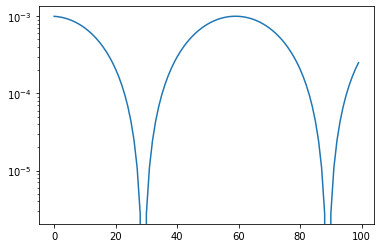

In [8]:
# optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8) # 0.75(20)-0.9(100)
# # gamma^step

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 30)

lr_list=[]
for x in range(100):
    scheduler.step()
    lr=optimizer.param_groups[0]["lr"]
    # print(lr)
    lr_list.append(lr)

import matplotlib.pyplot as plt
plt.plot(lr_list)
plt.yscale('log')
plt.show()


In [13]:
# @title wwwwwwwww
import time
start = time.time()
lr_list=[]
loss_fn = nn.CrossEntropyLoss()

batch_size = 512 # 4
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
ctrain_data = datasets.CIFAR10(root="data", train=True, download=True,transform=ToTensor(),)
ctrain_loader = DataLoader(ctrain_data, batch_size=batch_size)

base_lr ,max_lr = 1e-4, 1e-3
epochs = 10 #5 40
num_batches=int(np.ceil(len(train_data)/batch_size))
epochs = 10 #5 20
# (1e-5/1e-1)=gamma**(num_batches*epochs)
# gamma = np.exp(np.log(1e-3/1e-1)/epochs) # for scheduler step every epoch
gamma = np.exp(np.log(base_lr/max_lr)/(num_batches*epochs)) # for scheduler step every optimizer step
# print(gamma)

# optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-6)
# optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1, momentum=0.9)
optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=num_iter, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0, three_phase=True,)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=epochs, steps_per_epoch=num_batches, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0, three_phase=True,)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)

# coptimizer = torch.optim.SGD(model.classifier.parameters(), lr=1e-3)
coptimizer = torch.optim.AdamW(model.classifier.parameters(), lr=1e-3)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    lr=optimizer.param_groups[0]["lr"]
    lr_list.append(lr)
    print(lr)
    # train(train_loader, model, loss_fn, optimizer)
    strain(train_loader, model, loss_fn, optimizer, scheduler)
    # strain(train_loader, model, loss_fn, optimizer)
    train_classifier(ctrain_loader, model, loss_fn, coptimizer)
    test(test_loader, model, loss_fn)
    # scheduler.step()
print("Done!")

end = time.time()
print("time: ",end - start)

torch.save(model.state_dict(), "model.pth")

# model = NeuralNetwork().to(device)
# model.load_state_dict(torch.load("model.pth"))


Files already downloaded and verified
Epoch 1
-------------------------------
3.9999999999999996e-05
loss: 15.873966  [    0/50000]
loss: 15.494720  [ 4608/50000]
loss: 15.780310  [ 9216/50000]
loss: 15.541817  [13824/50000]
loss: 15.510596  [18432/50000]
loss: 15.513143  [23040/50000]
loss: 15.343438  [27648/50000]
loss: 15.292038  [32256/50000]
loss: 15.190303  [36864/50000]
loss: 15.277014  [41472/50000]
loss: 15.214978  [46080/50000]
loss: 1.818323  [    0/50000]
Test Error: 
 Accuracy: 34.9%, Avg loss: 1.770094 

Epoch 2
-------------------------------
0.0001527886758400849
loss: 15.120742  [    0/50000]
loss: 15.357693  [ 4608/50000]
loss: 15.043781  [ 9216/50000]
loss: 15.265494  [13824/50000]
loss: 15.054854  [18432/50000]
loss: 15.109354  [23040/50000]
loss: 14.908815  [27648/50000]
loss: 14.874107  [32256/50000]
loss: 14.989883  [36864/50000]
loss: 14.702206  [41472/50000]
loss: 14.960526  [46080/50000]
loss: 1.799736  [    0/50000]
Test Error: 
 Accuracy: 35.5%, Avg loss: 1.

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
# plt.yscale('log')
plt.show()

# plt.plot(lr_list)
plt.show()

# nooo

In [14]:
# @title save
from google.colab import drive
drive.mount('/content/gdrive')
PATH="/content/gdrive/MyDrive/torch_save/" # for saving to google drive
name='vicreg_res.pth'
# PATH="/content/" # for saving on colab only
# name='model.pth'

# torch.save(model.state_dict(), PATH+name)

model = NeuralNetwork().to(device)
model.load_state_dict(torch.load(PATH+name))


Mounted at /content/gdrive


<All keys matched successfully>

In [ ]:

def test():
    model.eval()
    n_correct = 0
    n_samples = 0
    with torch.no_grad():
        n_class_correct = [0 for i in range(10)]
        n_class_samples = [0 for i in range(10)]
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # outputs = model(images)
            sx = model(images)
            outputs = model.classify(sx)
            # max returns (value ,index)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            for i in range(batch_size):
                print(len(labels))
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1
        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')
        for i in range(10):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {classes[i]}: {acc} %')

test()

In [ ]:
classes = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot",]
model.eval()
import random
n=random.randint(0,1000)
print(n)
x, y = test_data[n]
# print(x)
with torch.no_grad():
    # pred = model(x.to(device))
    # print(pred)
    # predicted, actual = classes[pred[0].argmax(0)], classes[y]

    # x, y = x.to(device), y.to(device)
    x = x.to(device)
    sx = model(x)
    pred = model.classify(sx)
    pred = torch.argmax(pred, dim=1).item()
    print(pred)
    print(y)
    # predicted, actual = classes[pred[0].argmax(0)], classes[y]
    # print(f'Predicted: "{predicted}", Actual: "{actual}"')

